# Summary

Experiments with deriving metric tensors (in $\mathsf{T}\mathsf{M}$ and $\mathsf{T}^{*\!}\mathsf{M}$), Cartan torsion, the Christoffel coefficients (tensor), and the geodesic equation (plus spray coefficients).

### Preliminaries

In [1]:
import sympy as sy, numpy as np, os
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, trigsimp, expand, factor, powsimp, \
    Eq, solve, solveset, sqrt, diff, Matrix, det, tan, cos, sin, sec, csc, \
    Abs, Rational, pi, re, im, atan, atan2, numer, denom, \
    lambdify, log, collect, cancel, integrate, Integral, \
    nroots, poly, N

from gmplib.utils import e2d
from gme.symbols import *
from gme.equations import Equations

from functools import reduce

# Won't work for eta<1
# rdotz = symbols('v^z',  real=True, positive=True)

In [2]:
# from notebook.services.config import ConfigManager
# cm = ConfigManager().update('notebook', {'limit_output': 20000})

# Basics

In [3]:
gmeq = Equations( eta=Rational(1,2),  mu=Rational(1,4),
                  beta_type='sin', do_raw=True )

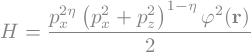

In [4]:
H_ = gmeq.H_eqn.rhs
gmeq.H_eqn

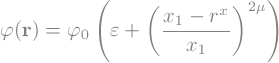

In [5]:
gmeq.varphi_rx_eqn

In [6]:
H1_ = H_.subs({varphi_r:1})
# Assume indexing here ranges in [1,2]
p_i_lambda = lambda i: [px, pz][i-1]
r_i_lambda = lambda i: [rx, rz][i-1]
rdot_i_lambda = lambda i: [rdotx, rdotz][i-1]

# Co-Finsler metric tensor  ${g}^{ij}$

### From  Hamilton's equations

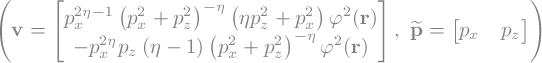

In [7]:
gmeq.rdot_vec_eqn, gmeq.p_covec_eqn

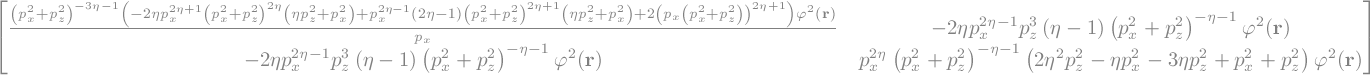

In [8]:
gstar_raw = simplify( Matrix([diff(gmeq.rdot_vec_eqn.rhs, gmeq.p_covec_eqn.rhs[0]).T,
                              diff(gmeq.rdot_vec_eqn.rhs, gmeq.p_covec_eqn.rhs[1]).T]) )
gstar_raw

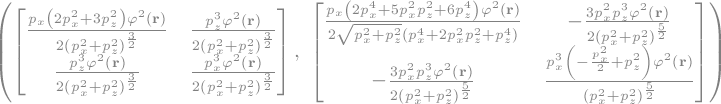

In [9]:
simplify( gstar_raw.subs({eta:Rational(1,2)}) ), simplify( gstar_raw.subs({eta:Rational(3,2)}) )

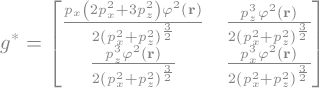

In [10]:
simplify( gmeq.gstar_varphi_pxpz_eqn  )

### From $H(\vec{r},\mathbf{p})$

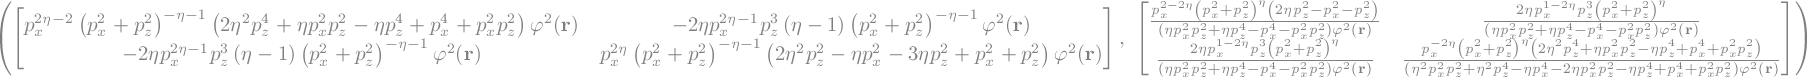

In [11]:
gstar_ij_lambda = lambda i,j: simplify( 
    Rational(2,2)*diff(diff(H_,p_i_lambda(i)),p_i_lambda(j)) )
gstar_mat = Matrix([[gstar_ij_lambda(1,1),gstar_ij_lambda(2,1)],
                    [gstar_ij_lambda(1,2),gstar_ij_lambda(2,2)]])
gstar_mat, simplify(gstar_mat.inv())

In [12]:
# gstar1_ij_lambda = lambda i,j: gstar_ij_lambda(i,j)
# Matrix([[gstar1_ij_lambda(1,1), gstar1_ij_lambda(2,1)],
#         [gstar1_ij_lambda(1,2), gstar1_ij_lambda(2,2)]])

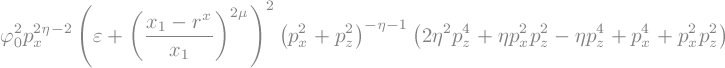

In [13]:
gstar_rx_ij_lambda = lambda i,j: gstar_ij_lambda(i,j).subs({varphi_r:gmeq.varphi_rx_eqn.rhs})
gstar_rx_ij_lambda(1,1)

In [14]:
gstar_det = simplify(gstar_mat.det())
gstar_det

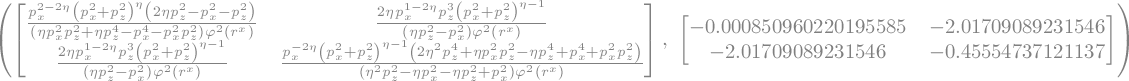

In [15]:
g_ij_pxpz_lambda = lambda i,j: simplify( 
    (gstar_ij_lambda(3-i,3-j)*(-1)**i*(-1)**j)/gstar_det ).subs({varphi_r:varphi_rx})
g_ij_pxpz_lambda_mat \
    = ( 
    Matrix([[g_ij_pxpz_lambda(1,1),g_ij_pxpz_lambda(2,1)],
            [g_ij_pxpz_lambda(1,2),g_ij_pxpz_lambda(2,2)]])
#                     .subs({eta:gmeq.eta})
#                     .subs({sqrt(px**2+pz**2):-sqrt(px**2+pz**2)})
      )
g_ij_pxpz_lambda_mat, g_ij_pxpz_lambda_mat.subs({varphi_rx:1, px:0.075, pz:-1, eta:gmeq.eta})

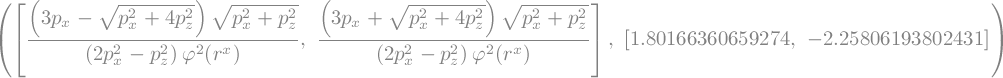

In [16]:
evcts = [factor(evct[0]) for evct in g_ij_pxpz_lambda_mat.subs({eta:gmeq.eta}).eigenvects()]
evcts, [evct.subs({varphi_rx:1, px:0.075, pz:-1}) for evct in evcts]

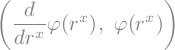

In [17]:
d_varphi_rx = Function(r'\varphi', real=True, positive=True)(rx)
diff(varphi_rx,rx),d_varphi_rx

### Determinant

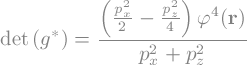

In [18]:
gmeq.det_gstar_varphi_pxpz_eqn

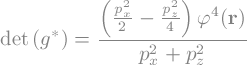

In [19]:
Eq(det_gstar,simplify(expand(gmeq.det_gstar_varphi_pxpz_eqn.rhs)
                      .subs(e2d(gmeq.tanbeta_pxpz_eqn, do_flip=True, do_negate=True))))

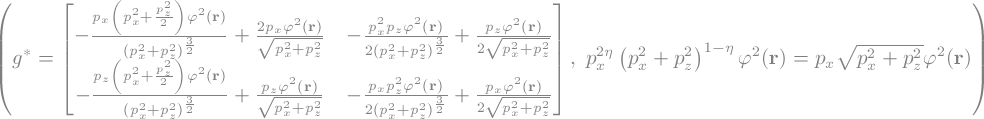

In [20]:
gstar_eqn = gmeq.gstar_varphi_pxpz_eqn
gstar_eqn, Eq( gmeq.Fstar_eqn.rhs**2, simplify(  gstar_eqn.rhs[0]*px*px 
                                               + gstar_eqn.rhs[1]*px*pz
                                               + gstar_eqn.rhs[2]*pz*px
                                               + gstar_eqn.rhs[3]*pz*pz ) )

# Metric tensor $g_{ij}$

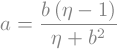

In [21]:
tab_eqn = gmeq.tanalpha_beta_eqn.subs({tan(alpha):ta, tan(beta):tb})
tab_eqn

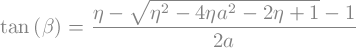

In [22]:
tanbeta_eqn = Eq(tan(beta), simplify( solve(tab_eqn, tb)[0] ))
tanbeta_eqn

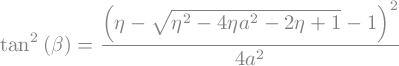

In [23]:
tan2beta_eqn = factor(Eq(tan(beta)**2,tanbeta_eqn.rhs**2))
tan2beta_eqn

In [24]:
gmeq.px_pz_tanbeta_eqn

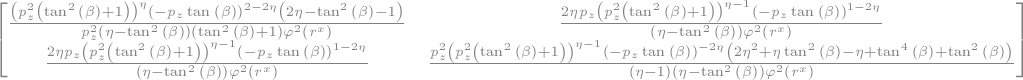

In [25]:
g_ij_tanbeta_lambda = lambda i,j: factor( g_ij_pxpz_lambda(i,j).subs(e2d(gmeq.px_pz_tanbeta_eqn)) ) 
Matrix([
    [g_ij_tanbeta_lambda(1,1),g_ij_tanbeta_lambda(1,2)],
    [g_ij_tanbeta_lambda(2,1),g_ij_tanbeta_lambda(2,2)]
])

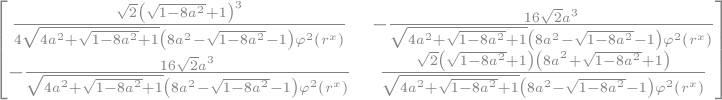

In [26]:
g_ij_ta_lambda = lambda i,j: factor( 
    g_ij_tanbeta_lambda(i,j)
    .subs({tanbeta_eqn.lhs:tanbeta_eqn.rhs, 
           tan2beta_eqn.lhs:tan2beta_eqn.rhs}).subs({eta:gmeq.eta})
)

Matrix([
    [g_ij_ta_lambda(1,1),g_ij_ta_lambda(1,2)],
    [g_ij_ta_lambda(2,1),g_ij_ta_lambda(2,2)]
])

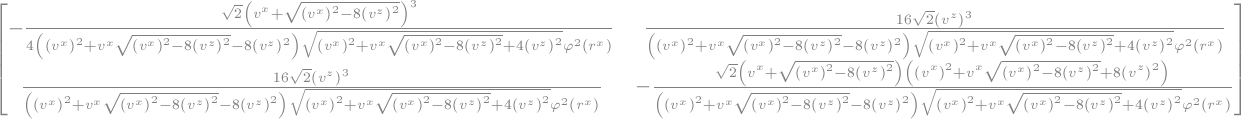

In [27]:
g_ij_rdotrx_lambda = lambda i,j: factor((g_ij_ta_lambda(i,j))
                                .subs({ta:tan(alpha)})
                                .subs(e2d(gmeq.tanalpha_rdot_eqn)) )
                                #.subs({gmeq.xi_rx_eqn.lhs:gmeq.xi_rx_eqn.rhs}))
Matrix([
    [g_ij_rdotrx_lambda(1,1),g_ij_rdotrx_lambda(1,2)],
    [g_ij_rdotrx_lambda(2,1),g_ij_rdotrx_lambda(2,2)]
])

# Cartan torsion

The Cartan torsion tensor is non-zero for Finsler spaces, so let's confirm by constructing the tensor and checking some coefficients.

In [28]:
C_ijk_lambda = lambda i_,j_,k_: ( 
    (Rational(1,2)*diff(g_ij_rdotrx_lambda(i_,j_),rdot_i_lambda(k_))
       .subs({varphi_rx:1})))

Picking a random-ish velocity and a couple of symmetric 
coefficients, we see that they are non-zero:

In [29]:
( N( C_ijk_lambda(1,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  N( C_ijk_lambda(1,2,1).subs({rdotx:0.1,rdotz:0.01}) ) )

Checking the torsion symmetry further, switching the first index reveals antisymmetry in the respective components:

In [30]:
( sy.N( C_ijk_lambda(2,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( C_ijk_lambda(2,2,1).subs({rdotx:0.1,rdotz:0.01}) ) )

In [31]:
# C_ijk_dict = {}
# for i in [1,2]:
#     for j in [1,2]:
#         for k in [1,2]:
#             C_ijk_ = Eq( symbols('C_{'+'{}{}{}'.format(i,j,k)+'}'),
#                          simplify(simplify(C_ijk_lambda(i,j,k).subs({cf:x}) )
#                                  .subs({Abs(rdotz):rdotz})) )
#             print(i,j,k)
#             C_ijk_dict.update({(i,j,k):C_ijk_})

In [32]:
# C_ijk = MatrixSymbol('C',1,8)
# C_ijk_raw = [(C_ijk_lambda(i_,j_,k_))
#              for i_ in [1,2] for j_ in [1,2] for k_ in [1,2]]
# C_ijk_eqn = Eq(C_ijk, Matrix(C_ijk_raw).T)


In [33]:
vC_ijk_raw = [(rdot_i_lambda(i_)*C_ijk_lambda(i_,j_,k_))
                       for i_ in [1,2] for j_ in [1,2] for k_ in [1,2]]
vC_ijk = (reduce(lambda a,b: a+b, vC_ijk_raw))

Picking a random-ish point in phase space, test to see if torsion is zero:

In [34]:
sy.N( vC_ijk.subs({rx:0.1,rdotx:0.9,rdotz:0.1}) )

which it is within numerical precision.

# Christoffel tensor (symbols)

In [35]:
gamma_i_jk_raw = lambda i_,j_,k_: [
    (Rational(1,2)*g_ij_rdotrx_lambda(i_,l_)*(
      diff(g_ij_rdotrx_lambda(l_,k_),r_i_lambda(j_)) 
    + diff(g_ij_rdotrx_lambda(j_,l_),r_i_lambda(k_))
    - diff(g_ij_rdotrx_lambda(j_,k_),r_i_lambda(l_)) )).subs({Abs(rdotz):rdotz}).subs({eta:gmeq.eta})
    for l_ in [1,2] ]
gamma_i_jk = lambda i_,j_,k_: factor( 
    reduce(lambda a,b: a+b, gamma_i_jk_raw(i_,j_,k_)   ) )

Check to see if symmetrically diagonal components are equal:

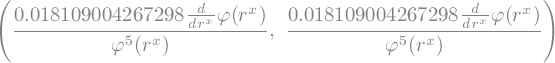

In [36]:
( sy.N( gamma_i_jk(1,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( gamma_i_jk(1,2,1).subs({rdotx:1,rdotz:0.1}) ) )

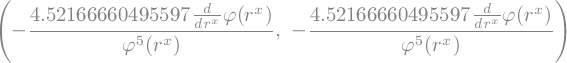

In [37]:
( sy.N( gamma_i_jk(2,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( gamma_i_jk(2,2,1).subs({rdotx:1,rdotz:0.1}) ) )

# Geodesic spray coefficients

In [38]:
G_i_lambda_raw = lambda i_: [(Rational(1,2)*gamma_i_jk(i_,j_,k_)
                    *rdot_i_lambda(j_)*rdot_i_lambda(k_)).subs({Abs(rdotz):rdotz})
                            for j_ in [1,2] for k_ in [1,2] ]
G_i_lambda = lambda i_: factor( reduce(lambda a,b: a+b, G_i_lambda_raw(i_)) )

In [39]:
G1_eqn = Eq(G1,G_i_lambda(1))
G2_eqn = Eq(G2,G_i_lambda(2))
G1_lambda = lambda rx_,rdotx_,rdotz_: \
                G1_eqn.rhs.subs({rx:rx_,rdotx:rdotx_,rdotz:rdotz_})
G2_lambda = lambda rx_,rdotx_,rdotz_: \
                G2_eqn.rhs.subs({rx:rx_,rdotx:rdotx_,rdotz:rdotz_})

\begin{equation}
    \dfrac{\mathrm{d}^2 r^i}{\mathrm{d}t^2} + 2G^i(r^j,{v}^j) = 0
\end{equation}

$G_1$ and $G_2$ are respectively the geodesic spray coefficients in $x$ and $z$.

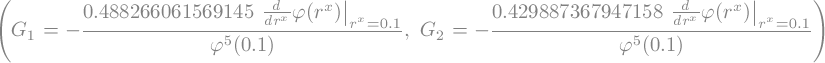

In [40]:
( Eq(G1,sy.N(G1_lambda(rx_=0.1,rdotx_=1,rdotz_=0.1))),
  Eq(G2,sy.N(G2_lambda(rx_=0.1,rdotx_=1,rdotz_=0.1))) )

In [41]:
# G1_eqn

In [42]:
# G2_eqn

### Euler 2-homogeneity of $G$

The geodesic coefficients are apparently positive 2-homogeneous in $\mathbf{v}$. We can check by computing $G_1$ and $G_2$ first for some random-ish values of $\mathbf{v}$, then for suitably scaled values of $\mathbf{v}$ (such as by a factor of $\times \,2.5$), and the comparing the square root ratio of each, which should return that factor.

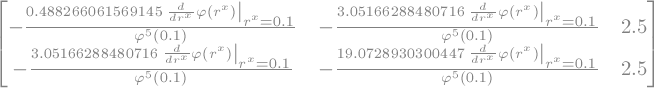

In [43]:
sf = 2.5; rdotx_,rdotz_ = (1,0.1)
G1_1_sf_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_*sf,rdotz_=rdotz_*sf))
G1_1_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_,rdotz_=rdotz_))
sf = 2.5; rdotx_,rdotz_ = (2.5,0.25)
G1_2_sf_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_*sf,rdotz_=rdotz_*sf))
G1_2_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_,rdotz_=rdotz_))
Matrix([[G1_1_, G1_1_sf_, sqrt(G1_1_sf_/G1_1_)], [G1_2_, G1_2_sf_, 
        sqrt(G1_2_sf_/G1_2_)]])

This is because the Christoffel symbols $\Gamma^i_{jk}$ are 0-homogeneous in ${\mathbf{v}}$, and because:

\begin{equation}
  G^i(\mathbf{\dot{r}}) = \tfrac{1}{2}\Gamma^i_{jk}(\mathbf{r}) {v}^j {v}^k
\end{equation}

which leads to a squared dependence on a scale factor in velocity.